In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing #model_selection, 
#from XGBoostPackage import xgbClass
#from CrossValidation import CVScore
from sklearn.grid_search import GridSearchCV

import xgboost as xgb
import datetime
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.cross_validation import train_test_split
#now = datetime.datetime.now()

train = pd.read_csv('./input/train_further_additional_feature.csv', parse_dates=['timestamp'])
test = pd.read_csv('./input/test_further_additional_feature.csv', parse_dates=['timestamp'])
macro = pd.read_csv('./input/macro.csv', parse_dates=['timestamp'])

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

id_test = test.id
#multiplier = 0.969

def RMSLE_(y_val, y_val_pred):
    return np.sqrt(np.mean((np.log(y_val+1)-np.log(y_val_pred+1))**2))
RMSLE = make_scorer(RMSLE_, greater_is_better=False) 

from time import time

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#train[['mean_price_persqm_raion','sub_area','year']][train['sub_area']=='Bibirevo']
dict1=dict(zip(train['sub_area'],train['mean_price_persqm_raion']))
test['mean_price_persqm_raion']=test['sub_area'].apply(lambda x: dict1[x])
del dict1
dict1=dict(zip(train['sub_area'],train['mean_price_raion']))
test['mean_price_raion']=test['sub_area'].apply(lambda x: dict1[x])
del dict1
dict1=dict(zip(zip(train['sub_area'],train['year']),train['mean_price_raion_year']))
test['mean_price_raion_year']=test.apply(lambda x: dict1[(x['sub_area'],x['year'])]\
                                         if (x['sub_area'],x['year']) in dict1 else np.nan,
                                         axis=1)
del dict1

In [3]:
#clean data
def build_year_clean(train):
    #train.build_year=train.build_year.apply(int)
    train.build_year[train.build_year == 20052009] = 2005
    train.build_year[train.build_year == 0] = np.NaN
    train.build_year[train.build_year == 1] = np.NaN
    train.build_year[train.build_year == 20] = 2000
    train.build_year[train.build_year == 215] = 2015
    train.build_year[train.build_year == 4965] = np.NaN     
    train.build_year[train.build_year == 3] = np.NaN
    train.build_year[train.build_year == 71] = np.NaN
build_year_clean(train)
build_year_clean(test)

bad_index = train[train.life_sq > train.full_sq].index
train.ix[bad_index, "life_sq"] = np.NaN
equal_index = [601,1896,2791]
test.ix[equal_index, "life_sq"] = test.ix[equal_index, "full_sq"]
bad_index = test[test.life_sq > test.full_sq].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.life_sq < 5].index
train.ix[bad_index, "life_sq"] = np.NaN
bad_index = test[test.life_sq < 5].index
test.ix[bad_index, "life_sq"] = np.NaN
bad_index = train[train.full_sq < 5].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[test.full_sq < 5].index
test.ix[bad_index, "full_sq"] = np.NaN
kitch_is_build_year = [13117]
train.ix[kitch_is_build_year, "build_year"] = train.ix[kitch_is_build_year, "kitch_sq"]
bad_index = train[train.kitch_sq >= train.life_sq].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[test.kitch_sq >= test.life_sq].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.kitch_sq == 0).values + (train.kitch_sq == 1).values].index
train.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = test[(test.kitch_sq == 0).values + (test.kitch_sq == 1).values].index
test.ix[bad_index, "kitch_sq"] = np.NaN
bad_index = train[(train.full_sq > 210) & (train.life_sq / train.full_sq < 0.3)].index
train.ix[bad_index, "full_sq"] = np.NaN
bad_index = test[(test.full_sq > 150) & (test.life_sq / test.full_sq < 0.3)].index
test.ix[bad_index, "full_sq"] = np.NaN
bad_index = train[train.life_sq > 300].index
train.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
bad_index = test[test.life_sq > 200].index
test.ix[bad_index, ["life_sq", "full_sq"]] = np.NaN
train.product_type.value_counts(normalize= True)
test.product_type.value_counts(normalize= True)
bad_index = train[train.build_year < 1500].index
train.ix[bad_index, "build_year"] = np.NaN
bad_index = test[test.build_year < 1500].index
test.ix[bad_index, "build_year"] = np.NaN
bad_index = train[train.num_room == 0].index 
train.ix[bad_index, "num_room"] = np.NaN
bad_index = test[test.num_room == 0].index 
test.ix[bad_index, "num_room"] = np.NaN
bad_index = [10076, 11621, 17764, 19390, 24007, 26713, 29172]
train.ix[bad_index, "num_room"] = np.NaN
bad_index = [3174, 7313]
test.ix[bad_index, "num_room"] = np.NaN
bad_index = train[(train.floor == 0).values * (train.max_floor == 0).values].index
train.ix[bad_index, ["max_floor", "floor"]] = np.NaN
bad_index = train[train.floor == 0].index
train.ix[bad_index, "floor"] = np.NaN
bad_index = train[train.max_floor == 0].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.max_floor == 0].index
test.ix[bad_index, "max_floor"] = np.NaN
bad_index = train[train.floor > train.max_floor].index
train.ix[bad_index, "max_floor"] = np.NaN
bad_index = test[test.floor > test.max_floor].index
test.ix[bad_index, "max_floor"] = np.NaN
train.floor.describe(percentiles= [0.9999])
bad_index = [23584]
train.ix[bad_index, "floor"] = np.NaN
train.material.value_counts()
test.material.value_counts()
train.state.value_counts()
bad_index = train[train.state == 33].index
train.ix[bad_index, "state"] = 3#np.NaN
test.state.value_counts()


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


2.0    2662
1.0    2266
3.0    1913
4.0     127
Name: state, dtype: int64

In [4]:
# brings error down a lot by removing extreme price per sqm
train.loc[train.full_sq == 0, 'full_sq'] = 50
train = train[train.price_doc/train.full_sq <= 600000]
train = train[train.price_doc/train.full_sq >= 10000]

# Add month-year
month_year = (train.timestamp.dt.month + train.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
train['month_year_cnt'] = month_year.map(month_year_cnt_map)

month_year = (test.timestamp.dt.month + test.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
test['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (train.timestamp.dt.weekofyear + train.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
train['week_year_cnt'] = week_year.map(week_year_cnt_map)

week_year = (test.timestamp.dt.weekofyear + test.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
test['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# def Time_Feature(train):
#     train['year'] = train.timestamp.dt.year
#     train['month'] = train.timestamp.dt.month
#     train['woy'] = train.timestamp.dt.weekofyear
#     train['dow'] = train.timestamp.dt.dayofweek
#     train['dom'] = train.timestamp.dt.days_in_month
# Time_Feature(train)
# Time_Feature(test)
# test['year'] = test.timestamp.dt.year
# test['month'] = test.timestamp.dt.month
# test['dow'] = test.timestamp.dt.dayofweek

# Other feature engineering
#train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
#train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)

#test['rel_floor'] = test['floor'] / test['max_floor'].astype(float)
#test['rel_kitch_sq'] = test['kitch_sq'] / test['full_sq'].astype(float)

# train.apartment_name=train.sub_area + train['metro_km_avto'].astype(str)
# test.apartment_name=test.sub_area + train['metro_km_avto'].astype(str)

# train['room_size'] = train['life_sq'] / train['num_room'].astype(float)
# test['room_size'] = test['life_sq'] / test['num_room'].astype(float)

# train['non_living_area'] = (train['full_sq']-train['life_sq'])*100/train['full_sq']
# test['non_living_area'] = (test['full_sq']-test['life_sq'])*100/train['full_sq']

# def House_Characteristics(train):
#     train['floor_from_top'] = train['max_floor'] - train['floor']
#     train['rel_floor'] = train['floor'] / train['max_floor'].astype(float)
#     train['room_size'] = (train['life_sq']-train['kitch_sq']) / train['num_room'].astype(float)
#     train['rel_kitch_sq'] = train['kitch_sq'] / train['full_sq'].astype(float)
#     train['rel_life_sq'] = train['life_sq'] / train['full_sq'].astype(float)
#     train['non_living_area'] = (train['full_sq']-train['life_sq'])*100/train['full_sq']
#     train['age_at_sale'] = (train['timestamp']-train['build_year'].apply(pd.to_datetime))/datetime.timedelta(days=365)

In [5]:
# ((train['timestamp']-train['build_year'].apply(pd.to_datetime))/datetime.timedelta(days=365)).hist()#
# #.apply(lambda x: x.total_seconds())

In [6]:
# plt.figure(figsize=(12,8))
# plt.subplot(2,2,1)
# sns.violinplot(data=train,x='year',y='price_doc')
# plt.ylim(-.1e8,.3e8)
# plt.subplot(2,2,2)
# sns.violinplot(data=train,x='month',y='price_doc')
# plt.ylim(-.1e8,.2e8)


In [7]:
train_lat_long=pd.read_csv("./input/train_lat_lon.csv")
test_lat_long=pd.read_csv("./input/test_lat_lon.csv")
# train_lat_long.head()

In [8]:
train=train.merge(train_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
del train_lat_long
test=test.merge(test_lat_long[["id","lat","lon"]],left_on='id',right_on='id')
del test_lat_long
train.loc[train['id']==11054]

,Unnamed: 0,sub_area,mean_building_height,mean_price_persqm_raion,year,mean_price_raion_year,mean_price_raion,distance_from_kremlin,year_month,n_sales_permonth,appartment_name,n,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_

In [9]:
# train.head()

In [10]:
# sns.lmplot(x="lon",y="lat",scatter_kws={'alpha':.4,'s':30}, size=9, fit_reg=False, data=train)
# axes=plt.gca()

In [11]:
import math
def cart2rho(x, y):
    rho = np.sqrt(x**2 + y**2)
    return rho


def cart2phi(x, y):
    phi = np.arctan2(y, x)
    return phi

#center long/lat of moscow: (37.6173, 55.7558)
def rotation_x(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return x*math.cos(alpha) + y*math.sin(alpha)


def rotation_y(row, alpha):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return y*math.cos(alpha) - x*math.sin(alpha)


def add_rotation(degrees, df):
    namex = "rot" + str(degrees) + "_X"
    namey = "rot" + str(degrees) + "_Y"

    df['num_' + namex] = df.apply(lambda row: rotation_x(row, math.pi/(180/degrees)), axis=1)
    df['num_' + namey] = df.apply(lambda row: rotation_y(row, math.pi/(180/degrees)), axis=1)

    return df

def add_dist_to_center(row):
    y = row['lat']-55.7558
    x = row['lon']-(37.6173)
    return cart2phi(x,y)

def operate_on_coordinates(tr_df, te_df):
    for df in [tr_df, te_df]:
        #polar coordinates system
#         df["num_rho"] = df.apply(lambda x: cart2rho(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         df["num_phi"] = df.apply(lambda x: cart2phi(x["latitude"] - 40.78222222, x["longitude"]+73.96527777), axis=1)
#         #rotations
        for angle in [30,60]:
            df = add_rotation(angle, df)
        df['dist_to_center']=df.apply(lambda row: add_dist_to_center(row), axis=1)

    return tr_df, te_df

train, test= operate_on_coordinates(train, test)

In [12]:
# sns.regplot(data=train.sample(1000),x="dist_to_center",y="price_doc")

In [13]:
# train['full_sq'].hist(bins=100, figsize=(12,8))

In [14]:
# y_train = train["price_doc"]
# X_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
# X_test = test.drop(["id", "timestamp"], axis=1)

y_train = train["price_doc"]
X_train = train.drop(["id", "timestamp", "price_doc", #'mean_price_raion_year', \
                      #'mean_price_raion', 'mean_price_persqm_raion', 
                      'Unnamed: 0'], axis=1)
X_test = test.drop(["id", "timestamp", 'Unnamed: 0'], axis=1)
X_test = X_test[X_train.columns]
del train
del test

## [1] "id"                       "id_metro"                
## [3] "id_railroad_station_walk" "id_railroad_station_avto"
## [5] "id_big_road1"             "id_big_road2"            
## [7] "id_railroad_terminal"     "id_bus_terminal"
#col_to_remove=["ID_metro","ID_railroad_station_walk","ID_railroad_station_avto","ID_big_road1","ID_big_road2","ID_railroad_terminal","ID_bus_terminal"]
def column_transform(X_train):
#     for c in col_to_remove:
#         del X_train[c]
    for c in X_train.columns:
        if X_train[c].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train[c].values)) 
            X_train[c] = lbl.transform(list(X_train[c].values))
            #X_train.drop(c,axis=1,inplace=True)
        
column_transform(X_train)
column_transform(X_test)

In [ ]:
t0=time()
xgbreg = xgb.XGBRegressor(learning_rate=.1, n_estimators=140, max_depth=5, gamma=0, \
                          max_depth=6, min_child_weight=3, seed=123,
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
modelelfit(xgbred, X_train, y_train)

In [17]:
t0=time()
xgbreg1 = xgb.XGBRegressor(learning_rate=.1, n_estimators=140, max_depth=5, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': np.arange(3,10,2),
       'min_child_weight': np.arange(1,6,2),
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg1, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.46512, std: 0.04719, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 1}, mean: -0.46517, std: 0.04657, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 3}, mean: -0.46485, std: 0.04743, params: {'seed': 123, 'max_depth': 3, 'min_child_weight': 5}, mean: -0.45962, std: 0.04770, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 1}, mean: -0.46006, std: 0.04766, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 3}, mean: -0.45899, std: 0.04654, params: {'seed': 123, 'max_depth': 5, 'min_child_weight': 5}, mean: -0.45951, std: 0.04869, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 1}, mean: -0.45867, std: 0.04793, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 3}, mean: -0.45908, std: 0.04807, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 5}, mean: -0.46190, std: 0.04855, params: {'seed': 123, 'max_depth': 9, 'min_child_weight': 1}, mean: -0.46050, std: 0.04

In [18]:
t0=time()
xgbreg2 = xgb.XGBRegressor(learning_rate=.1, n_estimators=140, max_depth=5, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'max_depth': [6,7,8],
       'min_child_weight': [2,3,4],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg2, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45922, std: 0.04754, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 2}, mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 3}, mean: -0.45936, std: 0.04719, params: {'seed': 123, 'max_depth': 6, 'min_child_weight': 4}, mean: -0.45957, std: 0.04813, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 2}, mean: -0.45867, std: 0.04793, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 3}, mean: -0.45855, std: 0.04784, params: {'seed': 123, 'max_depth': 7, 'min_child_weight': 4}, mean: -0.46029, std: 0.04869, params: {'seed': 123, 'max_depth': 8, 'min_child_weight': 2}, mean: -0.45933, std: 0.04830, params: {'seed': 123, 'max_depth': 8, 'min_child_weight': 3}, mean: -0.45938, std: 0.04774, params: {'seed': 123, 'max_depth': 8, 'min_child_weight': 4}], {'seed': 123, 'max_depth': 6, 'min_child_weight': 3})
Best CV Score:
0.45837768534
65.401110518


In [20]:
t0=time()
xgbreg3 = xgb.XGBRegressor(learning_rate=.1, n_estimators=140, max_depth=5, gamma=0, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
       'gamma' : [i/10.0 for i in np.arange(0,5)],
       'max_depth': [6],
       'min_child_weight': [3],
        'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg3, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 3}, mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'gamma': 0.10000000000000001, 'min_child_weight': 3}, mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'gamma': 0.20000000000000001, 'min_child_weight': 3}, mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'gamma': 0.29999999999999999, 'min_child_weight': 3}, mean: -0.45838, std: 0.04668, params: {'seed': 123, 'max_depth': 6, 'gamma': 0.40000000000000002, 'min_child_weight': 3}], {'seed': 123, 'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 3})
Best CV Score:
0.45837768534
13.3166464329


In [24]:
t0=time()
xgbreg4 = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/10.0 for i in np.arange(6,10)],
    'colsample_bytree':[i/10.0 for i in np.arange(6,10)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg4, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45945, std: 0.04623, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.59999999999999998}, mean: -0.46033, std: 0.04813, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.59999999999999998}, mean: -0.45945, std: 0.04730, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.59999999999999998}, mean: -0.45882, std: 0.04785, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.59999999999999998}, mean: -0.46003, std: 0.04820, params: {'subsample': 0.59999999999999998, 'colsample_bytree': 0.69999999999999996}, mean: -0.45919, std: 0.04872, params: {'subsample': 0.69999999999999996, 'colsample_bytree': 0.69999999999999996}, mean: -0.45861, std: 0.04726, params: {'subsample': 0.80000000000000004, 'colsample_bytree': 0.69999999999999996}, mean: -0.45895, std: 0.04830, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.69999999999999996}, mean: -0.45953, std: 0.04

In [26]:
t0=time()
xgbreg5 = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, \
                          subsample=.8, colsample_bytree=.8,nthread=-1,scale_pos_weight=1)
param_grid = {
    'subsample':[i/100.0 for i in np.arange(85,100,5)],
    'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg5, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45904, std: 0.04822, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.84999999999999998}, mean: -0.45837, std: 0.04670, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.84999999999999998}, mean: -0.45882, std: 0.04809, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.84999999999999998}, mean: -0.45958, std: 0.04835, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.90000000000000002}, mean: -0.45826, std: 0.04803, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.90000000000000002}, mean: -0.45914, std: 0.04841, params: {'subsample': 0.94999999999999996, 'colsample_bytree': 0.90000000000000002}, mean: -0.45884, std: 0.04801, params: {'subsample': 0.84999999999999998, 'colsample_bytree': 0.94999999999999996}, mean: -0.45842, std: 0.04831, params: {'subsample': 0.90000000000000002, 'colsample_bytree': 0.94999999999999996}, mean: -0.45822, std: 0.04

In [15]:
#del xgbreg
t0=time()
xgbreg6 = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.95,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[1e4,1e5,1e6,1e7]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg6, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45904, std: 0.04750, params: {'reg_alpha': 10000.0}, mean: -0.45798, std: 0.04727, params: {'reg_alpha': 100000.0}, mean: -0.45890, std: 0.04823, params: {'reg_alpha': 1000000.0}, mean: -0.45762, std: 0.04818, params: {'reg_alpha': 10000000.0}], {'reg_alpha': 10000000.0})
Best CV Score:
0.457621258027
13.308499519


In [17]:
#del xgbreg
t0=time()
xgbreg6 = xgb.XGBRegressor(learning_rate=.1, n_estimators=150, max_depth=6, gamma=0, \
                          min_child_weight=3, seed=123, reg_alpha=0,\
                          subsample=.95, colsample_bytree=.95,nthread=-1,scale_pos_weight=1)
param_grid = {
    'reg_alpha':[8e6,1e7, 1.5e7]#[1e-5, 1e-2, .1, 1, 100]
    #'subsample':[i/100.0 for i in np.arange(85,100,5)],
    #'colsample_bytree':[i/100.0 for i in np.arange(85,100,5)]
       #'gamma' : [0],
       #'max_depth': [6],
       #'min_child_weight': [3],
        #'seed':[123]#np.arange(20)
}
model = GridSearchCV(estimator=xgbreg6, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
model.fit(X_train, y_train)
print('eXtreme Gradient Boosting regression...')
print('Best Params:')
print(model.grid_scores_, model.best_params_)
print('Best CV Score:')
print(-model.best_score_)
print((time()-t0)/60)

eXtreme Gradient Boosting regression...
Best Params:
([mean: -0.45907, std: 0.04900, params: {'reg_alpha': 8000000.0}, mean: -0.45762, std: 0.04818, params: {'reg_alpha': 10000000.0}, mean: -0.45785, std: 0.04751, params: {'reg_alpha': 15000000.0}], {'reg_alpha': 10000000.0})
Best CV Score:
0.457621258027
10.931350414


In [34]:
xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.95,
    'min_child_weight':3,
    'colsample_bytree': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}
num_rounds=1000

X_fit, X_val, y_fit, y_val=train_test_split(X_train[:], y_train[:], test_size=0.2, \
                                            random_state=123)
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
#clfCV = xgb.train(xgb_params, xgfit, num_rounds)
clfCV = xgb.train(xgb_params, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
RMSLE_(y_val,y_val_pred)
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} 0.44153281251502002
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #year 
#0.44060260149809333
# {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5} #further feat
# 0.44209231186019138
# 'eta': 0.2, 'max_depth': 4,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.44795306064489548
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 5, 0.43906751173727021
# 'eta': 0.05, 'max_depth': 7,'subsample': 0.7,'colsample_bytree': 0.7,'objective': 'reg:linear','eval_metric': 'rmse',
#'silent': 1,'booster' :'gbtree','tuneLength': 3,'seed': 123, 0.43867312921244639

#'eta': 0.1,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44006308323535842

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.43956845066724409

#'eta': 0.05,'max_depth': 6,'subsample': 0.95,'min_child_weight':3,'colsample_bytree': 0.95,
#'objective': 'reg:linear','eval_metric': 'rmse','silent': 1,'booster' :'gbtree',
#'tuneLength': 3,'seed': 123, 0.44026780405377181

[0]	train-rmse:8.46674e+06	test-rmse:8.56184e+06
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 20 rounds.
[1]	train-rmse:8.39115e+06	test-rmse:8.48814e+06
[2]	train-rmse:8.31606e+06	test-rmse:8.41566e+06
[3]	train-rmse:8.24192e+06	test-rmse:8.3434e+06
[4]	train-rmse:8.16862e+06	test-rmse:8.27211e+06
[5]	train-rmse:8.09597e+06	test-rmse:8.20158e+06
[6]	train-rmse:8.02869e+06	test-rmse:8.13595e+06
[7]	train-rmse:7.9575e+06	test-rmse:8.06636e+06
[8]	train-rmse:7.88688e+06	test-rmse:7.99767e+06
[9]	train-rmse:7.81739e+06	test-rmse:7.92957e+06
[10]	train-rmse:7.74854e+06	test-rmse:7.86251e+06
[11]	train-rmse:7.68007e+06	test-rmse:7.79456e+06
[12]	train-rmse:7.6126e+06	test-rmse:7.72744e+06
[13]	train-rmse:7.54599e+06	test-rmse:7.66268e+06
[14]	train-rmse:7.48003e+06	test-rmse:7.59849e+06
[15]	train-rmse:7.41467e+06	test-rmse:7.53516e+06
[16]	train-rmse:7.35011e+06	test-rmse:7.47183e+06
[17]	train-rmse:7.28

0.44026780405377181

In [16]:
# t0=time()
# xgbreg = xgb.XGBRegressor()
# param_grid = {
#        #'n_estimators': [500],
#        'learning_rate': [0.05, .15, .2, .25], #[.05], #
#        'max_depth': [3, 4,5,6,7],
#        'subsample': [.65, 0.7, .75], #[.7], #
#        'colsample_bytree': [.65, 0.7, 0.75], #[.7],#
#         'seed':[123]#np.arange(20)
# }
# model = GridSearchCV(estimator=xgbreg, param_grid=param_grid, n_jobs=-1, cv=5, scoring=RMSLE)
# model.fit(X_train, y_train)
# print('eXtreme Gradient Boosting regression...')
# print('Best Params:')
# print(model.best_params_)
# print('Best CV Score:')
# print(-model.best_score_)
# print((time()-t0)/60)




# # eXtreme Gradient Boosting regression...
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 5, 'colsample_bytree': 0.7, 'max_depth': 5}
# # Best CV Score:
# # 0.468277454751
# ##################
# # eXtreme Gradient Boosting regression...
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.045, 'seed': 123, 'colsample_bytree': 0.65, 'max_depth': 6}
# # Best CV Score:
# # 0.466023945905
# # {'subsample': 0.75, 'learning_rate': 0.045, 'seed': 123, 'colsample_bytree': 0.75, 'max_depth': 7}
# # Best CV Score:
# # 0.464491819425
# # Best Params:
# # {'subsample': 0.7, 'learning_rate': 0.05, 'seed': 123, 'colsample_bytree': 0.7, 'max_depth': 7}
# # Best CV Score:
# # 0.460651355555

param_grid = {'eta':[.05], 'num_round':[500], 'subsample':[.7], 'colsample_bytree':[.7], \
              'max_depth':[5], 'seed':[2017,213,5]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    for num_rounds in param_grid['num_round']:
                        model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='rmse', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='reg:linear', num_class=1,num_rounds=num_rounds,\
                                       early_stopping_rounds=20)
                        score=CVScore(model=model, n_splits=3, my_score=RMSLE, X_train=X_train,\
                                  y_train=y_train)
                        del model
                        print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}, num_rounds={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score, num_rounds))

[0]	train-rmse:7.80073e+06	test-rmse:7.81478e+06
[50]	train-rmse:1.88359e+06	test-rmse:2.57174e+06
[100]	train-rmse:1.67833e+06	test-rmse:2.53747e+06
[150]	train-rmse:1.53642e+06	test-rmse:2.53196e+06


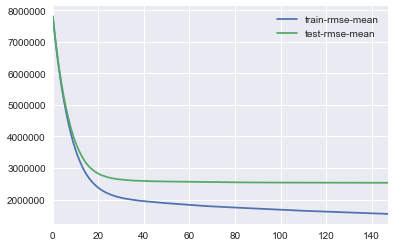

In [21]:
xgb_params = {
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 6,
    'subsample': 0.8,
    'min_child_weight': 3,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'seed': 123
}

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [18]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

#fig, ax = plt.subplots(1, 1, figsize=(8, 13))
#xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

y_predict = model.predict(dtest)
#y_predict = np.round(y_predict)#np.round(y_predict * 0.99)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})



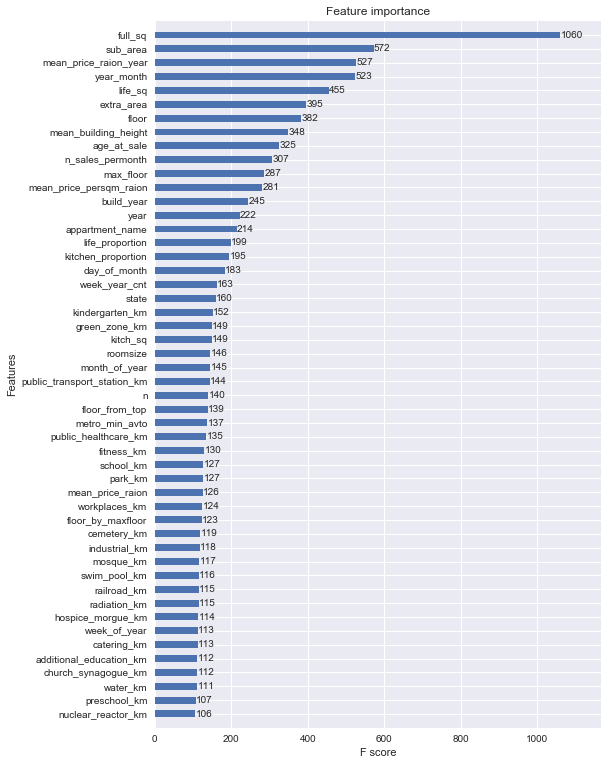

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [20]:
 output.to_csv('submission_Jun7_3_seed123_furtherFeat.csv', index=False)